# Imports



In [ ]:
from google.colab import drive
basePath = "/content/drive/My Drive/Colab Notebooks/Artificial Intelligence/"
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import keras
print("Keras version:", keras.__version__)

TensorFlow version: 2.17.1
Keras version: 3.5.0


In [ ]:
import numpy as np
import cv2
import os
import random
import shutil
import pandas as pd
import csv
import zipfile
import tensorflow as tf
import keras
import fnmatch
import glob
import matplotlib.pyplot as plt
import nibabel as nib
import matplotlib.pyplot as plt
import matplotlib

from keras import optimizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dropout, Flatten, Dense,Input
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.initializers import RandomNormal
from matplotlib.image import imread

# Testing ResNet50 (ImageNet weights) on image slice

In [ ]:
img = nib.load(basePath + "TB_Caverns_Data/TRN_10.nii.gz")
data = img.get_fdata()
print(data[0])
print(img.header)
print(img.affine)

[[-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 ...
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]
 [-2048. -2048. -2048. ... -2048. -2048. -2048.]]
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b'r'
dim_info        : 0
dim             : [  3 512 512 357   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [1.00000e+00 6.94000e-01 6.94000e-01 8.00000e-01 0.00000e+00 1.00000e+00
 1.00000e+00 5.25277e+04]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 10
cal_max         : 0.0
cal_min         

(512, 512, 357)


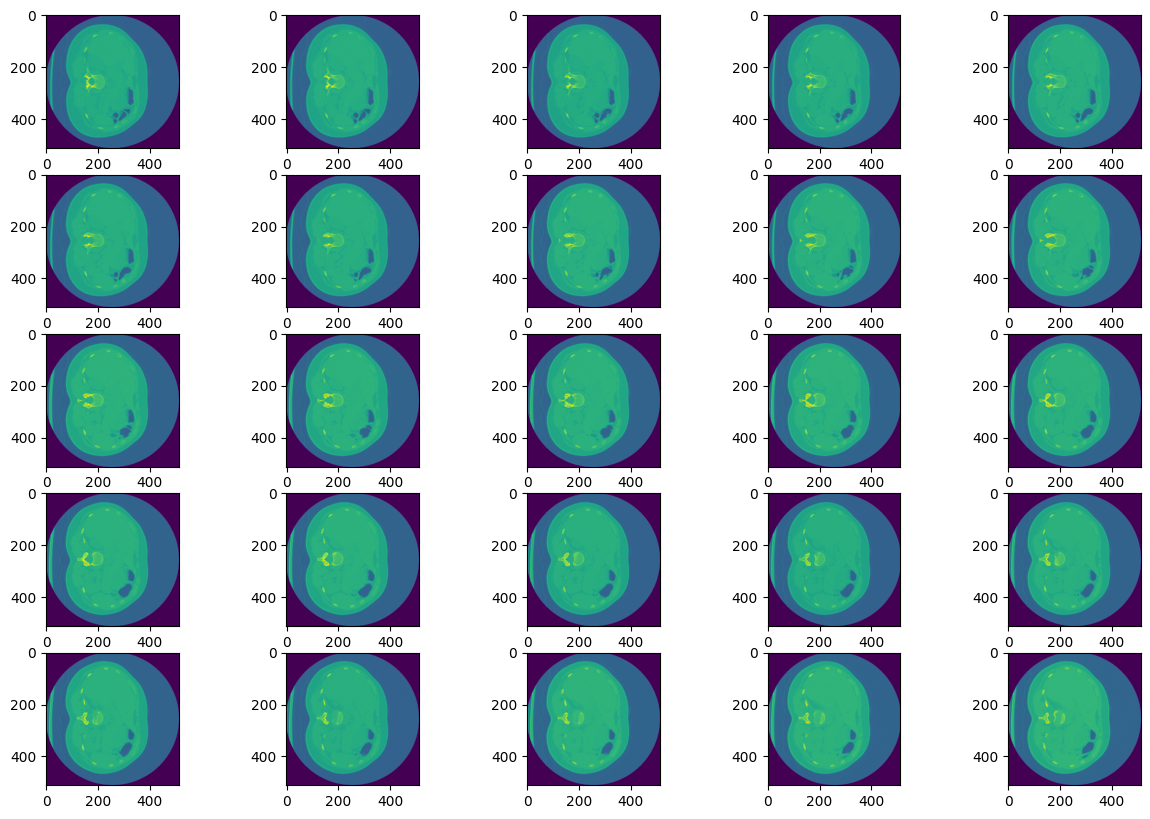

In [ ]:
print(img.shape)
for i in range(data.shape[2]):
    if i <= 24:
      plt.subplot(5, 5,i + 1)
      plt.imshow(data[:,:,0 + i])
      plt.gcf().set_size_inches(15, 10)
    else:
      break
plt.show()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

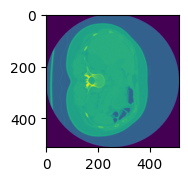

1/1 [==============================] - 2s 2s/step
Predicted: [('n02782093', 'balloon', 0.29910663), ('n09229709', 'bubble', 0.08771338), ('n01910747', 'jellyfish', 0.08295924)]


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from PIL import Image

model = ResNet50(weights='imagenet')
print(model.summary())

slice = data[:, :, 0]

plt.subplot(5, 5, 1)
plt.imshow(slice)
plt.gcf().set_size_inches(15, 10)
plt.show()

matplotlib.image.imsave('slice.png', slice)

newsize = (224, 224)
im1 = Image.open("slice.png")
im1 = im1.resize(newsize)

img_path = "slice.png"

img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

# Modify colab GPU memory limitations

In [ ]:
tf.config.list_physical_devices('GPU')
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
#gpus = tf.config.experimental.list_physical_devices('GPU')
#for gpu in gpus:
  #tf.config.experimental.set_memory_growth(gpu, True)

# Grabbing all images into train_folders (parsed later)

In [ ]:
train_folders = [f.name for f in os.scandir(basePath + "Project/train_jpgs_folders/") if f.is_dir() and not len(os.listdir(basePath + "Project/train_jpgs_folders/" + f.name)) <= 10]
print(train_folders)

['TRN_53', 'TRN_28', 'TRN_29', 'TRN_55', 'TRN_12', 'TRN_56', 'TRN_25', 'TRN_08', 'TRN_27', 'TRN_44', 'TRN_17', 'TRN_06', 'TRN_30', 'TRN_59', 'TRN_45', 'TRN_31', 'TRN_14', 'TRN_33', 'TRN_39', 'TRN_36', 'TRN_38', 'TRN_51', 'TRN_19', 'TRN_47', 'TRN_49', 'TRN_26', 'TRN_07', 'TRN_41', 'TRN_23', 'TRN_58', 'TRN_21', 'TRN_18', 'TRN_42', 'TRN_52', 'TRN_50', 'TRN_10', 'TRN_15', 'TRN_43', 'TRN_40', 'TRN_32', 'TRN_54', 'TRN_20', 'TRN_04', 'TRN_13', 'TRN_09', 'TRN_05', 'TRN_22', 'TRN_34', 'TRN_46', 'TRN_03', 'TRN_35', 'TRN_48', 'TRN_37', 'TRN_57', 'TRN_00', 'TRN_01', 'TRN_02']


# Split images into training, validation, and testing folders

In [ ]:
# Randomize the folder order
import random
random.seed(42)  # for reproducibility
shuffled_folders = train_folders.copy()
random.shuffle(shuffled_folders)

# Calculate splits (keeping your proportions)
total_folders = len(shuffled_folders)
n_test = 11
n_val = 11
n_train = total_folders - (n_test + n_val)

# Split into sets
new_train_folders = shuffled_folders[:n_train]
validation_folders = shuffled_folders[n_train:n_train+n_val]
test_folders = shuffled_folders[n_train+n_val:]

# Print results
print("new_train_folders:", new_train_folders)
print("Number of training folders:", len(new_train_folders))
print("\nvalidation_folders:", validation_folders)
print("Number of validation folders:", len(validation_folders))
print("\ntest_folders:", test_folders)
print("Number of test folders:", len(test_folders))

new_train_folders: ['TRN_15', 'TRN_47', 'TRN_48', 'TRN_06', 'TRN_14', 'TRN_38', 'TRN_37', 'TRN_01', 'TRN_52', 'TRN_36', 'TRN_44', 'TRN_05', 'TRN_18', 'TRN_10', 'TRN_21', 'TRN_20', 'TRN_55', 'TRN_51', 'TRN_46', 'TRN_12', 'TRN_58', 'TRN_17', 'TRN_40', 'TRN_19', 'TRN_32', 'TRN_49', 'TRN_53', 'TRN_04', 'TRN_26', 'TRN_03', 'TRN_39', 'TRN_23', 'TRN_22', 'TRN_07', 'TRN_30']
Number of training folders: 35

validation_folders: ['TRN_02', 'TRN_42', 'TRN_35', 'TRN_59', 'TRN_09', 'TRN_00', 'TRN_29', 'TRN_41', 'TRN_43', 'TRN_56', 'TRN_50']
Number of validation folders: 11

test_folders: ['TRN_13', 'TRN_25', 'TRN_57', 'TRN_27', 'TRN_45', 'TRN_31', 'TRN_33', 'TRN_34', 'TRN_28', 'TRN_08', 'TRN_54']
Number of test folders: 11


In [ ]:
def check_distribution(folders, base_path, labels_df):
    folder_labels = []
    for folder in folders:
        # Get all slices for this folder
        folder_data = labels_df[labels_df['ID'].str.startswith(folder)]

        # Calculate mean for each label
        folder_means = {
            'thick_walls': folder_data['thick_walls'].mean(),
            'has_calcification': folder_data['has_calcification'].mean(),
            'foci_around': folder_data['foci_around'].mean()
        }
        folder_labels.append(folder_means)

    return pd.DataFrame(folder_labels).mean()

# Load your labels
labels_df = pd.read_csv(basePath + "TB_Caverns_Data/TB_y_train.csv")  # adjust path as needed

print("\nDetailed class distributions:")
print("\nTraining:")
print(check_distribution(new_train_folders, basePath, labels_df))
print("\nValidation:")
print(check_distribution(validation_folders, basePath, labels_df))
print("\nTesting:")
print(check_distribution(test_folders, basePath, labels_df))

# Also check counts per set
print("\nNumber of slices per set:")
for folder_set, name in [(new_train_folders, "Training"),
                        (validation_folders, "Validation"),
                        (test_folders, "Testing")]:
    n_slices = sum(len(os.listdir(basePath + f"Project/train_jpgs_folders/{folder}"))
                   for folder in folder_set)
    print(f"{name}: {n_slices} slices")


Detailed class distributions:

Training:
thick_walls          0.771429
has_calcification    0.542857
foci_around          0.485714
dtype: float64

Validation:
thick_walls          0.909091
has_calcification    0.727273
foci_around          0.545455
dtype: float64

Testing:
thick_walls          0.909091
has_calcification    0.545455
foci_around          0.454545
dtype: float64

Number of slices per set:
Training: 11678 slices
Validation: 3200 slices
Testing: 3969 slices


In [ ]:
new_train_folders = train_folders[:-11]
validation_folders = new_train_folders[-11:]
new_train_folders = new_train_folders[:-11]
test_folders = train_folders[-11:]
print("new_train_folders:" + str(new_train_folders))
print(len(new_train_folders))
print("validation_folders:" + str(validation_folders))
print(len(validation_folders))
print("test_folders:" + str(test_folders))
print(len(test_folders))

new_train_folders:['TRN_53', 'TRN_28', 'TRN_29', 'TRN_55', 'TRN_12', 'TRN_56', 'TRN_25', 'TRN_08', 'TRN_27', 'TRN_44', 'TRN_17', 'TRN_06', 'TRN_30', 'TRN_59', 'TRN_45', 'TRN_31', 'TRN_14', 'TRN_33', 'TRN_39', 'TRN_36', 'TRN_38', 'TRN_51', 'TRN_19', 'TRN_47', 'TRN_49', 'TRN_26', 'TRN_07', 'TRN_41', 'TRN_23', 'TRN_58', 'TRN_21', 'TRN_18', 'TRN_42', 'TRN_52', 'TRN_50']
35
validation_folders:['TRN_10', 'TRN_15', 'TRN_43', 'TRN_40', 'TRN_32', 'TRN_54', 'TRN_20', 'TRN_04', 'TRN_13', 'TRN_09', 'TRN_05']
11
test_folders:['TRN_22', 'TRN_34', 'TRN_46', 'TRN_03', 'TRN_35', 'TRN_48', 'TRN_37', 'TRN_57', 'TRN_00', 'TRN_01', 'TRN_02']
11


In [ ]:
# Get per-folder statistics with actual slice counts
folder_stats = {}
for folder in train_folders:
    # Get actual number of slices
    n_slices = len(os.listdir(basePath + f"Project/train_jpgs_folders/{folder}"))

    # Get label data
    folder_data = labels_df[labels_df['ID'].str.startswith(folder)]

    folder_stats[folder] = {
        'thick_walls': folder_data['thick_walls'].mean(),
        'has_calcification': folder_data['has_calcification'].mean(),
        'foci_around': folder_data['foci_around'].mean(),
        'n_slices': n_slices
    }

# Convert to DataFrame for easier analysis
folder_df = pd.DataFrame.from_dict(folder_stats, orient='index')

# Print summary sorted by number of slices
print("Folders sorted by slice count:")
print(folder_df.sort_values('n_slices', ascending=False).head(10))

# Print total slices and label distributions for potential splits
def analyze_split(folders):
    total_slices = sum(folder_df.loc[folders, 'n_slices'])
    avg_labels = {
        'thick_walls': folder_df.loc[folders, 'thick_walls'].mean(),
        'has_calcification': folder_df.loc[folders, 'has_calcification'].mean(),
        'foci_around': folder_df.loc[folders, 'foci_around'].mean()
    }
    return total_slices, avg_labels

print("\nCurrent split analysis:")
for split_name, folders in [("Training", new_train_folders),
                          ("Validation", validation_folders),
                          ("Testing", test_folders)]:
    slices, labels = analyze_split(folders)
    print(f"\n{split_name}:")
    print(f"Total slices: {slices}")
    print("Label distributions:", labels)

Folders sorted by slice count:
        thick_walls  has_calcification  foci_around  n_slices
TRN_52          1.0                1.0          0.0       611
TRN_46          1.0                0.0          0.0       557
TRN_33          1.0                1.0          0.0       547
TRN_50          1.0                1.0          1.0       545
TRN_26          0.0                0.0          0.0       515
TRN_47          1.0                0.0          0.0       481
TRN_29          1.0                1.0          1.0       479
TRN_32          1.0                1.0          0.0       477
TRN_55          1.0                0.0          1.0       471
TRN_34          1.0                1.0          0.0       457

Current split analysis:

Training:
Total slices: 11965
Label distributions: {'thick_walls': 0.8, 'has_calcification': 0.5428571428571428, 'foci_around': 0.4857142857142857}

Validation:
Total slices: 2955
Label distributions: {'thick_walls': 0.9090909090909091, 'has_calcification': 0.6

In [ ]:
# Example swaps to balance distributions
swaps = {
    'val_to_train': ['TRN_50', 'TRN_29'],  # High slice count, mixed labels
    'train_to_val': ['TRN_26', 'TRN_46'],  # Include some negative cases
}

# Test the new distribution
new_train = [f for f in new_train_folders if f not in swaps['train_to_val']] + swaps['val_to_train']
new_val = [f for f in validation_folders if f not in swaps['val_to_train']] + swaps['train_to_val']

print("\nProposed new split analysis:")
print("\nNew Training:")
slices, labels = analyze_split(new_train)
print(f"Total slices: {slices}")
print("Label distributions:", labels)

print("\nNew Validation:")
slices, labels = analyze_split(new_val)
print(f"Total slices: {slices}")
print("Label distributions:", labels)


Proposed new split analysis:

New Training:
Total slices: 12474
Label distributions: {'thick_walls': 0.8333333333333334, 'has_calcification': 0.5833333333333334, 'foci_around': 0.5277777777777778}

New Validation:
Total slices: 4027
Label distributions: {'thick_walls': 0.8461538461538461, 'has_calcification': 0.5384615384615384, 'foci_around': 0.38461538461538464}


In [ ]:
# Function to calculate absolute difference in distributions
def distribution_difference(train_folders, val_folders):
    train_slices, train_labels = analyze_split(train_folders)
    val_slices, val_labels = analyze_split(val_folders)

    # Calculate differences for each metric
    diffs = {
        'thick_walls': abs(train_labels['thick_walls'] - val_labels['thick_walls']),
        'has_calcification': abs(train_labels['has_calcification'] - val_labels['has_calcification']),
        'foci_around': abs(train_labels['foci_around'] - val_labels['foci_around']),
    }

    # Return total difference and individual differences
    return sum(diffs.values()), diffs

# Try different combinations of swaps
best_swaps = {'train_to_val': [], 'val_to_train': []}
best_diff = float('inf')

# Get folders with high slice counts for potential swaps
high_slice_folders = folder_df[folder_df['n_slices'] > 400].index.tolist()

print("Testing folder swaps...")
for train_swap in high_slice_folders:
    if train_swap in new_train_folders:
        for val_swap in high_slice_folders:
            if val_swap in validation_folders:
                # Create temporary new splits
                temp_train = [f for f in new_train_folders if f != train_swap] + [val_swap]
                temp_val = [f for f in validation_folders if f != val_swap] + [train_swap]

                # Calculate distribution difference
                total_diff, diffs = distribution_difference(temp_train, temp_val)

                if total_diff < best_diff:
                    best_diff = total_diff
                    best_swaps = {
                        'train_to_val': [train_swap],
                        'val_to_train': [val_swap]
                    }
                    best_diffs = diffs

# Print results for best swaps
print("\nBest swaps found:")
print(f"Move from training to validation: {best_swaps['train_to_val']}")
print(f"Move from validation to training: {best_swaps['val_to_train']}")

# Show resulting distributions
new_train = [f for f in new_train_folders if f not in best_swaps['train_to_val']] + best_swaps['val_to_train']
new_val = [f for f in validation_folders if f not in best_swaps['val_to_train']] + best_swaps['train_to_val']

print("\nResulting distributions:")
print("\nNew Training:")
slices, labels = analyze_split(new_train)
print(f"Total slices: {slices}")
print("Label distributions:", labels)

print("\nNew Validation:")
slices, labels = analyze_split(new_val)
print(f"Total slices: {slices}")
print("Label distributions:", labels)

# Print folder details for proposed swaps
print("\nDetails of proposed swap folders:")
print("\nMoving from training:")
for folder in best_swaps['train_to_val']:
    print(f"{folder}:")
    print(folder_df.loc[folder])

print("\nMoving from validation:")
for folder in best_swaps['val_to_train']:
    print(f"{folder}:")
    print(folder_df.loc[folder])

Testing folder swaps...

Best swaps found:
Move from training to validation: ['TRN_45']
Move from validation to training: ['TRN_32']

Resulting distributions:

New Training:
Total slices: 11997
Label distributions: {'thick_walls': 0.8285714285714286, 'has_calcification': 0.5714285714285714, 'foci_around': 0.4857142857142857}

New Validation:
Total slices: 2923
Label distributions: {'thick_walls': 0.8181818181818182, 'has_calcification': 0.5454545454545454, 'foci_around': 0.45454545454545453}

Details of proposed swap folders:

Moving from training:
TRN_45:
thick_walls            0.0
has_calcification      0.0
foci_around            0.0
n_slices             445.0
Name: TRN_45, dtype: float64

Moving from validation:
TRN_32:
thick_walls            1.0
has_calcification      1.0
foci_around            0.0
n_slices             477.0
Name: TRN_32, dtype: float64


In [ ]:
train_folders = [f.name for f in os.scandir(basePath + "Project/train_jpgs_folders/")
                if f.is_dir() and not len(os.listdir(basePath + "Project/train_jpgs_folders/" + f.name)) <= 10]

# Start with your base splits
new_train_folders = train_folders[:-11]  # Remove last 11 for test
validation_folders = new_train_folders[-11:]  # Take last 11 for validation
new_train_folders = new_train_folders[:-11]  # Remove validation folders from train
test_folders = train_folders[-11:]  # Last 11 folders for test

# Apply our optimized swap
# Move TRN_26 from train to validation
new_train_folders.remove('TRN_26')
validation_folders.append('TRN_26')

# Move TRN_29 from validation to train
#print(validation_folders)
#validation_folders.remove('TRN_29')
new_train_folders.append('TRN_29')

# Print final splits to verify
print("new_train_folders:", new_train_folders)
print("Number of training folders:", len(new_train_folders))
print("\nvalidation_folders:", validation_folders)
print("Number of validation folders:", len(validation_folders))
print("\ntest_folders:", test_folders)
print("Number of test folders:", len(test_folders))

# Verify distributions one last time
def check_distribution(folders):
    folder_data = []
    for folder in folders:
        folder_data.append({
            'thick_walls': folder_df.loc[folder, 'thick_walls'],
            'has_calcification': folder_df.loc[folder, 'has_calcification'],
            'foci_around': folder_df.loc[folder, 'foci_around']
        })
    return pd.DataFrame(folder_data).mean()

print("\nFinal distributions:")
print("\nTraining:", check_distribution(new_train_folders))
print("\nValidation:", check_distribution(validation_folders))
print("\nTesting:", check_distribution(test_folders))

new_train_folders: ['TRN_53', 'TRN_28', 'TRN_29', 'TRN_55', 'TRN_12', 'TRN_56', 'TRN_25', 'TRN_08', 'TRN_27', 'TRN_44', 'TRN_17', 'TRN_06', 'TRN_30', 'TRN_59', 'TRN_45', 'TRN_31', 'TRN_14', 'TRN_33', 'TRN_39', 'TRN_36', 'TRN_38', 'TRN_51', 'TRN_19', 'TRN_47', 'TRN_49', 'TRN_07', 'TRN_41', 'TRN_23', 'TRN_58', 'TRN_21', 'TRN_18', 'TRN_42', 'TRN_52', 'TRN_50', 'TRN_29']
Number of training folders: 35

validation_folders: ['TRN_10', 'TRN_15', 'TRN_43', 'TRN_40', 'TRN_32', 'TRN_54', 'TRN_20', 'TRN_04', 'TRN_13', 'TRN_09', 'TRN_05', 'TRN_26']
Number of validation folders: 12

test_folders: ['TRN_22', 'TRN_34', 'TRN_46', 'TRN_03', 'TRN_35', 'TRN_48', 'TRN_37', 'TRN_57', 'TRN_00', 'TRN_01', 'TRN_02']
Number of test folders: 11

Final distributions:

Training: thick_walls          0.828571
has_calcification    0.571429
foci_around          0.514286
dtype: float64

Validation: thick_walls          0.833333
has_calcification    0.583333
foci_around          0.416667
dtype: float64

Testing: thick

In [ ]:
def analyze_slice_positions(base_path, folder_prefix):
    """Analyzes slices for a specific TRN prefix in a directory"""
    slices = sorted([f for f in os.listdir(base_path)
                    if f.startswith(folder_prefix) and f.endswith('.jpg')])
    if not slices:
        print(f"No jpg files found for {folder_prefix} in {base_path}")
        return {}

    total_slices = len(slices)
    slice_positions = {}
    for i, slice_name in enumerate(slices):
        position_ratio = i / total_slices
        position = 'start' if position_ratio < 0.25 else 'end' if position_ratio > 0.75 else 'middle'
        slice_positions[slice_name] = position

    return slice_positions

def balance_slice_distribution(train_dir, val_dir, train_folders, val_folders):
    train_positions = {folder: analyze_slice_positions(train_dir, folder)
                      for folder in train_folders}
    val_positions = {folder: analyze_slice_positions(val_dir, folder)
                    for folder in val_folders}

    train_dist = {'start': 0, 'middle': 0, 'end': 0}
    val_dist = {'start': 0, 'middle': 0, 'end': 0}

    for positions in train_positions.values():
        for pos in positions.values():
            train_dist[pos] += 1
    for positions in val_positions.values():
        for pos in positions.values():
            val_dist[pos] += 1

    return train_dist, val_dist

train_dir = basePath + "Project/training/resized/"
val_dir = basePath + "Project/validating/resized/"

train_dist, val_dist = balance_slice_distribution(train_dir, val_dir, new_train_folders, validation_folders)
print("Training distribution:", train_dist)
print("Validation distribution:", val_dist)

No jpg files found for TRN_26 in /content/drive/My Drive/Colab Notebooks/Artificial Intelligence/Project/validating/resized/
Training distribution: {'start': 2879, 'middle': 5726, 'end': 2845}
Validation distribution: {'start': 743, 'middle': 1480, 'end': 732}


# Resize training images from (512, 512) to (224, 224)

*May have to run this twice to get all resized image folders*

Note that Errno 17 code will execute for each time a new folder is worked on by the program

New folder make take 1-2 minutes to load in storage

In [ ]:
try:
    os.mkdir(basePath + "TB_Caverns_Data/training/resized/")
except OSError as error:
    print(error)

for folder in new_train_folders:
  dir_list = os.listdir(basePath + "Project/train_jpgs_folders/" + folder + "/")
  for filename in dir_list:
    if filename[:6] == folder:
      image = cv2.imread(basePath + "Project/train_jpgs_folders/" + folder + "/" + filename)
      up_points = (224,224)
      resized_down = cv2.resize(image, up_points, interpolation=cv2.INTER_LINEAR)
      cv2.imwrite(os.path.join(basePath + "TB_Caverns_Data/training/resized/", filename), resized_down)

# Resize validating images from (512, 512) to (224, 224)

In [ ]:
try:
    os.mkdir(basePath + "TB_Caverns_Data/validating/resized/")
except OSError as error:
    print(error)

[Errno 17] File exists: '/content/drive/My Drive/Colab Notebooks/Artificial Intelligence/TB_Caverns_Data/validating/resized/'


*May have to run this twice to get all resized image folders*

Note that Errno 17 code will execute for each time a new folder is worked on by the program

New folder make take 1-2 minutes to load in storage

In [ ]:
for folder in validation_folders:
  dir_list = os.listdir(basePath + "Project/train_jpgs_folders/" + folder + "/")
  for filename in dir_list:
    if filename[:6] == folder:
      image = cv2.imread(basePath + "Project/train_jpgs_folders/" + folder + "/" + filename)
      up_points = (224,224)
      resized_down = cv2.resize(image, up_points, interpolation=cv2.INTER_LINEAR)
      cv2.imwrite(os.path.join(basePath + "TB_Caverns_Data/validating/resized/", filename), resized_down)

# Resize testing images from (512, 512) to (224, 224)

In [ ]:
try:
    os.mkdir(basePath + "TB_Caverns_Data/testing/resized/")
except OSError as error:
    print(error)

[Errno 17] File exists: '/content/drive/My Drive/Colab Notebooks/Artificial Intelligence/TB_Caverns_Data/testing/resized/'


In [ ]:
for folder in test_folders:
  dir_list = os.listdir(basePath + "Project/train_jpgs_folders/" + folder + "/")
  for filename in dir_list:
    if filename[:6] == folder:
      image = cv2.imread(basePath + "Project/train_jpgs_folders/" + folder + "/" + filename)
      up_points = (224,224)
      resized_down = cv2.resize(image, up_points, interpolation=cv2.INTER_LINEAR)
      cv2.imwrite(os.path.join(basePath + "TB_Caverns_Data/testing/resized/", filename), resized_down)

# Creating .csv file of slices and respective labels (training data)

In [ ]:
f1=open(basePath + "TB_Caverns_Data/TB_y_train.csv")

df = pd.DataFrame(columns=('ID', 'thick_walls', 'has_calcification', 'foci_around'))

i = 0
reader = csv.reader(f1)
dir_list = os.listdir(basePath + "TB_Caverns_Data/training/resized/")
for file in dir_list:
  for row in reader:
    if file[:6] == row[0]:
      df.loc[i] = [file, row[1], row[2], row[3]]
      i+=1
  f1.seek(0)
print(df.shape)

# 1. Print the exact path where we're trying to save
print("Attempting to save to:", basePath + "TB_Caverns_Data/training/all_train.csv")

# 2. Save with explicit error catching
try:
    # Save with verbose settings
    df.to_csv(basePath + "TB_Caverns_Data/training/all_train.csv", index=False)
    print("CSV save operation completed")

    # Verify file was created
    if os.path.exists(basePath + "TB_Caverns_Data/training/all_train.csv"):
        print("File exists after saving!")
        print("File size:", os.path.getsize(basePath + "TB_Caverns_Data/training/all_train.csv"), "bytes")

        # Read back first few lines to verify content
        print("\nFirst few lines of saved file:")
        with open(basePath + "TB_Caverns_Data/training/all_train.csv", 'r') as f:
            print(f.readline())  # header
            print(f.readline())  # first data row
    else:
        print("File was not created!")

except Exception as e:
    print("Error during save operation:", str(e))

# 3. List directory contents
print("\nDirectory contents:")
print(os.listdir(basePath + "TB_Caverns_Data/training/"))

#df.to_csv(basePath + "TB_Caverns_Data/training/all_train.csv")
df = df.iloc[0:0]

(11450, 4)
Attempting to save to: /content/drive/My Drive/Colab Notebooks/Artificial Intelligence/TB_Caverns_Data/training/all_train.csv
CSV save operation completed
File exists after saving!
File size: 297791 bytes

First few lines of saved file:
ID,thick_walls,has_calcification,foci_around

TRN_53-slice294.jpg,1,1,0


Directory contents:
['resized', 'all_train.csv']


# Creating .csv file of slices and respective labels (validation data)

In [ ]:
f1=open(basePath + "TB_Caverns_Data/TB_y_train.csv")

df = pd.DataFrame(columns=('ID', 'thick_walls', 'has_calcification', 'foci_around'))

i = 0
reader = csv.reader(f1)
dir_list = os.listdir(basePath + "TB_Caverns_Data/validating/resized/")
for file in dir_list:
  for row in reader:
    if file[:6] == row[0]:
      #print(str(file[:6]) + " == " + str(row[0]))

      df.loc[i] = [file, row[1], row[2], row[3]]
      i+=1
  f1.seek(0)

# 1. Print the exact path where we're trying to save
print("Attempting to save to:", basePath + "TB_Caverns_Data/validating/all_validate.csv")

# 2. Save with explicit error catching
try:
    # Save with verbose settings
    df.to_csv(basePath + "TB_Caverns_Data/validating/all_validate.csv", index=False)
    print("CSV save operation completed")

    # Verify file was created
    if os.path.exists(basePath + "TB_Caverns_Data/validating/all_validate.csv"):
        print("File exists after saving!")
        print("File size:", os.path.getsize(basePath + "TB_Caverns_Data/validating/all_validate.csv"), "bytes")

        # Read back first few lines to verify content
        print("\nFirst few lines of saved file:")
        with open(basePath + "TB_Caverns_Data/validating/all_validate.csv", 'r') as f:
            print(f.readline())  # header
            print(f.readline())  # first data row
    else:
        print("File was not created!")

except Exception as e:
    print("Error during save operation:", str(e))

# 3. List directory contents
print("\nDirectory contents:")
print(os.listdir(basePath + "TB_Caverns_Data/validating/"))

#df.to_csv(basePath + "TB_Caverns_Data/validating/all_validate.csv")
df = df.iloc[0:0]

Attempting to save to: /content/drive/My Drive/Colab Notebooks/Artificial Intelligence/TB_Caverns_Data/validating/all_validate.csv
CSV save operation completed
File exists after saving!
File size: 90265 bytes

First few lines of saved file:
ID,thick_walls,has_calcification,foci_around

TRN_10-slice311.jpg,1,1,0


Directory contents:
['resized', 'all_validate.csv']


# Creating .csv file of slices and respective labels (test data)

In [ ]:
f1=open(basePath + "TB_Caverns_Data/TB_y_train.csv")

df = pd.DataFrame(columns=('ID', 'thick_walls', 'has_calcification', 'foci_around'))

i = 0
reader = csv.reader(f1)
dir_list = os.listdir(basePath + "TB_Caverns_Data/testing/resized/")
for file in dir_list:
  for row in reader:
    if file[:6] == row[0]:
      df.loc[i] = [file, row[1], row[2], row[3]]
      i+=1
  f1.seek(0)

# 1. Print the exact path where we're trying to save
print("Attempting to save to:", basePath + "TB_Caverns_Data/testing/all_test.csv")

# 2. Save with explicit error catching
try:
    # Save with verbose settings
    df.to_csv(basePath + "TB_Caverns_Data/testing/all_test.csv", index=False)
    print("CSV save operation completed")

    # Verify file was created
    if os.path.exists(basePath + "TB_Caverns_Data/testing/all_test.csv"):
        print("File exists after saving!")
        print("File size:", os.path.getsize(basePath + "TB_Caverns_Data/testing/all_test.csv"), "bytes")

        # Read back first few lines to verify content
        print("\nFirst few lines of saved file:")
        with open(basePath + "TB_Caverns_Data/testing/all_test.csv", 'r') as f:
            print(f.readline())  # header
            print(f.readline())  # first data row
    else:
        print("File was not created!")

except Exception as e:
    print("Error during save operation:", str(e))

# 3. List directory contents
print("\nDirectory contents:")
print(os.listdir(basePath + "TB_Caverns_Data/testing/"))

#df.to_csv(basePath + "TB_Caverns_Data/testing/all_test.csv")
df = df.iloc[0:0]

Attempting to save to: /content/drive/My Drive/Colab Notebooks/Artificial Intelligence/TB_Caverns_Data/testing/all_test.csv
CSV save operation completed
File exists after saving!
File size: 102147 bytes

First few lines of saved file:
ID,thick_walls,has_calcification,foci_around

TRN_22-slice356.jpg,1,1,1


Directory contents:
['resized', 'all_test.csv']


In [ ]:
train_df = pd.read_csv(basePath + "TB_Caverns_Data/training/all_train.csv")
val_df = pd.read_csv(basePath + "TB_Caverns_Data/validating/all_validate.csv")
test_df = pd.read_csv(basePath + "TB_Caverns_Data/testing/all_test.csv")

# Concatenate all three DataFrames vertically (stacking them on top of each other)
master_df = pd.concat([train_df, val_df, test_df], axis=0)

# Reset the index to have continuous numbering
master_df = master_df.reset_index(drop=True)

# Optional: Let's add a column to identify which set each row came from
# This might be useful later for analysis or verification
master_df['data_split'] = 'train'  # Set default value
n_train = len(train_df)
n_val = len(val_df)
master_df.loc[n_train:n_train + n_val - 1, 'data_split'] = 'validation'
master_df.loc[n_train + n_val:, 'data_split'] = 'test'

# Now we can see how many entries we have from each source
print("Total rows in master DataFrame:", len(master_df))
print("\nRows by data split:")
print(master_df['data_split'].value_counts())

Total rows in master DataFrame: 18847

Rows by data split:
data_split
train         11450
test           3927
validation     3470
Name: count, dtype: int64


In [ ]:
def create_patient_wise_split(dataframe):
    """
    This function would replace your current train/validation split logic.
    Instead of using predetermined folder lists, it would create the splits
    based on patient IDs.
    """
    patient_ids = dataframe['ID'].apply(lambda x: x.split('_')[1].split('-')[0]).unique()
    train_patients, val_patients = train_test_split(patient_ids, test_size=0.2, random_state=42)

    train_df = dataframe[dataframe['ID'].apply(lambda x: x.split('_')[1].split('-')[0]).isin(train_patients)]
    val_df = dataframe[dataframe['ID'].apply(lambda x: x.split('_')[1].split('-')[0]).isin(val_patients)]

    return train_df, val_df

def create_non_overlapping_sequences(dataframe, sequence_length=3):
    """
    This function would modify how we create sequences of slices for our model.
    It would be used inside your generator function to ensure we're creating
    proper, non-overlapping sequences.
    """
    sequences = []
    for patient in dataframe['ID'].apply(lambda x: x.split('_')[1].split('-')[0]).unique():
        patient_slices = dataframe[dataframe['ID'].apply(
            lambda x: x.split('_')[1].split('-')[0]) == patient].sort_values('slice_num')

        for i in range(0, len(patient_slices) - sequence_length + 1, sequence_length):
            sequence = patient_slices.iloc[i:i + sequence_length]
            if len(sequence) == sequence_length:
                sequences.append(sequence)

    return pd.concat(sequences)

new_train_df, new_val_df = create_patient_wise_split(master_df)

# Resnet50 model creation (testing and validation)

In [ ]:
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Add, Dense, GaussianNoise, Lambda, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling2D, TimeDistributed, ConvLSTM2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from sklearn.utils.class_weight import compute_class_weight
#from keras.utils import layer_utils
#from tensorflow.keras.utils import layer_utils
#from keras.utils.data_utils import get_file
import pydot
from IPython.display import SVG
#from keras.utils.vis_utils import model_to_dot
from tensorflow.keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

In [ ]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on thleir position in the network

    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)


    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)


    return X

In [ ]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4

    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used

    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path (≈3 lines)
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = Activation('relu')(X)


    # Third component of main path (≈2 lines)
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)


    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = Conv2D(filters = F3, kernel_size = (1, 1), strides = (s,s), padding = 'valid', name = conv_name_base + '1',
                        kernel_initializer = glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis = 3, name = bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)


    return X

In [ ]:
def ResNet50(input_shape=(224, 224, 3), classes=3, weights='imagenet', include_top=True):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer= glorot_uniform(seed=0), kernel_regularizer=l2(0.01), activity_regularizer=l2(0.01))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)
    X = Dropout(0.2)(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f = 3, filters = [128, 128, 512], stage = 3, block='a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], stage = 4, block='a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], stage = 5, block='a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = AveragePooling2D((2,2), name="avg_pool")(X)

    # DROPOUT
    X = Dropout(0.2)(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='sigmoid', name='fc' + str(classes), kernel_initializer = glorot_uniform(seed=0))(X)


    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

![link text](https://drive.google.com/uc?export=view&id=1Z_A8RiUuzLWD4bvKKMmqw4LUefkq-08Z)

In [ ]:
# Create local directories
!mkdir -p /content/data/TB_Caverns_Data_1/training/resized
!mkdir -p /content/data/TB_Caverns_Data_1/validating/resized
!mkdir -p /content/data/TB_Caverns_Data_1/testing/resized

# Copy data from Drive to local storage
!cp -r "{basePath}TB_Caverns_Data/training/resized/" "/content/data/TB_Caverns_Data_1/training/"
!cp -r "{basePath}TB_Caverns_Data/validating/resized/" "/content/data/TB_Caverns_Data_1/validating/"
!cp -r "{basePath}TB_Caverns_Data/testing/resized/" "/content/data/TB_Caverns_Data_1/testing/"
!cp "{basePath}TB_Caverns_Data/training/all_train.csv" "/content/data/TB_Caverns_Data_1/training/"
!cp "{basePath}TB_Caverns_Data/validating/all_validate.csv" "/content/data/TB_Caverns_Data_1/validating/"
!cp "{basePath}TB_Caverns_Data/testing/all_test.csv" "/content/data/TB_Caverns_Data_1/testing/"

In [ ]:
def calculate_slice_weights(train_dir, train_folders):
    """
    Calculates weights for each slice based on its position in the scan.
    Assigns higher weights to underrepresented positions (start/end) to balance learning.

    Args:
        train_dir: Base directory containing training slices
        train_folders: List of TRN folder prefixes

    Returns:
        Dictionary mapping slice names to their weights
    """
    # First, get position information for all slices
    slice_positions = {}
    for folder in train_folders:
        positions = analyze_slice_positions(train_dir, folder)
        slice_positions.update(positions)

    # Count total slices in each position
    position_counts = {'start': 0, 'middle': 0, 'end': 0}
    for position in slice_positions.values():
        position_counts[position] += 1

    # Calculate inverse weights (fewer samples = higher weight)
    total_samples = sum(position_counts.values())
    position_weights = {
        pos: total_samples / (3 * count)  # Multiply by 3 since we have 3 positions
        for pos, count in position_counts.items()
    }

    # Assign weights to individual slices
    slice_weights = {
        slice_name: position_weights[position]
        for slice_name, position in slice_positions.items()
    }

    return slice_weights

In [ ]:
def load_and_preprocess_image(image_path):
    # Load the image using TensorFlow's image processing
    # target_size=(224, 224) matches ResNet50's expected input
    img = tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=(224, 224)
    )

    # Convert the loaded image to a numpy array
    # This creates an array of shape (224, 224, 3)
    img_array = tf.keras.preprocessing.image.img_to_array(img)

    # Normalize pixel values to [0,1] range by dividing by 255
    # Neural networks typically perform better with normalized inputs
    img_array = img_array / 255.0

    return img_array

In [ ]:
def create_sequence_aware_generator(dataframe, datagen, directory, batch_size=128, sequence_length=3):
    """
    Creates a generator that yields batches of sequences in the correct format for TensorFlow.
    This version ensures proper data types and shapes for model training.
    """
    df_sorted = dataframe.copy()

    def extract_slice_number(filename):
        parts = filename.split('slice')[1]
        parts = parts.replace('.jpg', '')
        parts = parts.replace(' ', '')
        base_number = parts.split('(')[0]
        return int(base_number)

    # Process and sort our data
    df_sorted['slice_num'] = df_sorted['ID'].apply(extract_slice_number)
    df_sorted['patient_num'] = df_sorted['ID'].apply(
        lambda x: x.split('_')[1].split('-')[0]
    )
    df_sorted = df_sorted.sort_values(['patient_num', 'slice_num'])

    while True:
        # Initialize batch arrays
        batch_images = []
        batch_labels = []

        # Group by patient to keep sequences within same patient
        for patient_num, patient_group in df_sorted.groupby('patient_num'):
            if len(patient_group) >= sequence_length:
                # Create sliding windows within each patient's slices
                for i in range(len(patient_group) - sequence_length + 1):
                    sequence = patient_group.iloc[i:i + sequence_length]

                    # Load images for this sequence
                    sequence_images = []
                    valid_sequence = True

                    for _, row in sequence.iterrows():
                        try:
                            img_path = os.path.join(directory, row['ID'])
                            img = load_and_preprocess_image(img_path)
                            sequence_images.append(img)
                        except Exception as e:
                            print(f"Error loading image {img_path}: {str(e)}")
                            valid_sequence = False
                            break

                    if valid_sequence and len(sequence_images) == sequence_length:
                        # Convert sequence to numpy array
                        sequence_array = np.stack(sequence_images, axis=0)
                        labels = sequence.iloc[sequence_length//2][
                            ['thick_walls', 'has_calcification', 'foci_around']
                        ].values.astype(np.float32)  # Ensure float32 type

                        batch_images.append(sequence_array)
                        batch_labels.append(labels)

                        # Yield batch when it reaches the desired size
                        if len(batch_images) == batch_size:
                            X_batch = np.stack(batch_images, axis=0)
                            y_batch = np.stack(batch_labels, axis=0)

                            # Clear batch lists
                            batch_images = []
                            batch_labels = []

                            yield X_batch, y_batch

In [ ]:
import numpy as np
import os
from PIL import Image

def make_weighted_generator(dataframe, datagen, directory, slice_weights, batch_size=128, sequence_length=3):
    """
    Diagnostic sequence generator with extensive error checking
    """
    # Create sequences first
    sequence_df = create_non_overlapping_sequences(dataframe, sequence_length)

    # Verification of sequence structure
    print("\nSequence DataFrame Verification:")
    print(f"Sequence DataFrame columns: {list(sequence_df.columns)}")
    print("First few sequences:")
    print(sequence_df.head())

    # Prepare valid sequences
    valid_sequences = []

    for _, group in sequence_df.groupby(np.arange(len(sequence_df)) // sequence_length):
        # Extract full sequence of image IDs
        sequence_files = group['ID'].tolist()

        # Comprehensive file existence check with logging
        existing_files = []
        for file in sequence_files:
            full_path = os.path.join(directory, file.strip())
            if os.path.exists(full_path):
                existing_files.append(file)
            #else:
                #print(f"Missing file: {full_path}")

        # Only add sequence if all files exist
        if len(existing_files) == sequence_length:
            valid_sequences.append({
                'files': existing_files,
                'thick_walls': group['thick_walls'].mean(),
                'has_calcification': group['has_calcification'].mean(),
                'foci_around': group['foci_around'].mean()
            })

    print("\nValid Sequences Summary:")
    print(f"Total valid sequences: {len(valid_sequences)}")

    def generate_batches():
        while True:
            # Prepare batch data
            X_batch = []
            y_batch = []

            # Randomly sample sequences
            batch_sequences = np.random.choice(valid_sequences, batch_size, replace=True)

            for sequence_info in batch_sequences:
                # Prepare the sequence of images
                sequence_images = []
                for file in sequence_info['files']:
                    img_path = os.path.join(directory, file.strip())

                    # Load and preprocess image
                    img = Image.open(img_path)
                    img = img.resize((224, 224))
                    img = img.convert('RGB')
                    img_array = np.array(img) / 255.0

                    sequence_images.append(img_array)

                # Ensure sequence shape is correct
                assert len(sequence_images) == sequence_length, \
                    f"Sequence length mismatch. Expected {sequence_length}, got {len(sequence_images)}"

                X_batch.append(sequence_images)
                y_batch.append([
                    sequence_info['thick_walls'],
                    sequence_info['has_calcification'],
                    sequence_info['foci_around']
                ])

            # Convert to numpy arrays with explicit shape
            X_batch = np.array(X_batch)
            y_batch = np.array(y_batch)

            # Diagnostic print to verify shape
            #print("\nBatch Shape Verification:")
            #print(f"X_batch shape: {X_batch.shape}")
            #print(f"y_batch shape: {y_batch.shape}")

            # Verify shape matches model expectation
            assert X_batch.shape == (batch_size, sequence_length, 224, 224, 3), \
                f"Unexpected X_batch shape. Got {X_batch.shape}"

            yield X_batch, y_batch

    return generate_batches()

In [ ]:
def create_sequence_aware_model(sequence_length=3):
    """
    Creates a sequence-aware model with built-in class balancing
    and regularization techniques.
    """
    input_shape = (sequence_length, 224, 224, 3)
    inputs = Input(shape=input_shape)

    x = GaussianNoise(0.2)(inputs)

    # Process each time step with the same CNN layers
    x = TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2), padding='same',
                              kernel_regularizer=tf.keras.regularizers.l2(0.05)))(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = TimeDistributed(Activation('relu'))(x)
    x = TimeDistributed(Dropout(0.5))(x)  # Add dropout
    x = TimeDistributed(MaxPooling2D((3, 3), strides=(2, 2), padding='same'))(x)

    # Add ConvLSTM with regularization
    x = ConvLSTM2D(
        filters=32,
        kernel_size=(3, 3),
        padding='same',
        return_sequences=False,
        kernel_regularizer=tf.keras.regularizers.l2(0.03),
        recurrent_regularizer=tf.keras.regularizers.l2(0.03)
    )(x)

    x = Dropout(0.6)(x)  # Add more dropout
    x = GlobalAveragePooling2D()(x)

    # Add a dense layer with strong regularization
    x = Dense(64,
              activation='relu',
              kernel_regularizer=tf.keras.regularizers.l2(0.03))(x)
    x = Dropout(0.7)(x)

    outputs = Dense(3, activation='sigmoid')(x)

    model = Model(inputs, outputs)

    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00005),
        loss='binary_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.AUC(name='auc'),
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall')]
    )

    model.summary()

    return model

In [ ]:
def calculate_class_weights(y_train):
    """
    Calculates balanced class weights for each of the three prediction targets.
    """
    class_weights = []
    for i in range(3):  # For each prediction target
        labels = y_train[:, i]
        counts = np.bincount(labels.astype(int))
        total = len(labels)
        weights = {
            0: total / (2 * counts[0]),
            1: total / (2 * counts[1])
        }
        class_weights.append(weights)
    return class_weights

In [ ]:
def weighted_binary_crossentropy(class_weights):
    def loss(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        weights = y_true * class_weights[1] + (1 - y_true) * class_weights[0]
        return K.mean(bce * weights)
    return loss

In [ ]:
#from keras.layers.normalization.batch_normalization import BatchNormalization
import tensorflow.keras.backend as K
import gc

#del model
K.clear_session() #Clear keras backend
tf.compat.v1.reset_default_graph() #Clear keras backend
gc.collect()

TEST_SIZE = len(fnmatch.filter(os.listdir(basePath + "TB_Caverns_Data/training/"), '*.csv'))
#print(TEST_SIZE)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    zoom_range=0.15,
    fill_mode='nearest',
    cval=0.0)
test_datagen = ImageDataGenerator(rescale=1./255)

model = ResNet50()

#x = base_model.output
#x = GlobalAveragePooling2D()(x)
#x = Dense(1024, activation='relu')(x)
#x = Dropout(0.2)(x)
#predictions = Dense(3, activation='sigmoid')(x)  # 3 binary outputs

# Updated paths
train_dir = "/content/data/TB_Caverns_Data_1/training/resized/"
validate_dir = "/content/data/TB_Caverns_Data_1/validating/resized/"
test_dir = "/content/data/TB_Caverns_Data_1/testing/resized/"
train_df = pd.read_csv("/content/data/TB_Caverns_Data_1/training/all_train.csv")
validating_df = pd.read_csv("/content/data/TB_Caverns_Data_1/validating/all_validate.csv")
testing_df = pd.read_csv("/content/data/TB_Caverns_Data_1/testing/all_test.csv")

#pos_weights = []
#for col in ["thick_walls", "has_calcification", "foci_around"]:
#    n_pos = train_df[col].sum()
#    n_neg = len(train_df) - n_pos
#    weight = n_neg / n_pos
#    pos_weights.append(weight)

#print("Positive class weights:", pos_weights)

#model.compile(optimizer=tf.keras.optimizers.AdamW(
#    learning_rate=0.00005, clipnorm=1.0),
#    loss=weighted_binary_crossentropy(class_weights),
    #loss_weights=pos_weights,
#    metrics=['accuracy',
#             tf.keras.metrics.AUC(name='auc'),
#             tf.keras.metrics.Precision(name='precision'),
#             tf.keras.metrics.Recall(name='recall'),
#             tf.keras.metrics.TruePositives(name='tp'),
#             tf.keras.metrics.TrueNegatives(name='tn'),
#             tf.keras.metrics.FalsePositives(name='fp'),
#             tf.keras.metrics.FalseNegatives(name='fn')
#            ]
#    )

slice_weights = calculate_slice_weights(train_dir, new_train_folders)

#train_sequence = create_sequence_aware_generator(train_df, train_datagen, train_dir, batch_size=128)
#validation_sequence = create_sequence_aware_generator(validating_df, test_datagen, validate_dir, batch_size=128)

def extract_slice_number(filename):
        parts = filename.split('slice')[1]
        parts = parts.replace('.jpg', '')
        parts = parts.replace(' ', '')
        base_number = parts.split('(')[0]
        return int(base_number)

new_train_df['slice_num'] = new_train_df['ID'].apply(extract_slice_number)
new_val_df['slice_num'] = new_val_df['ID'].apply(extract_slice_number)

train_sequence = make_weighted_generator(new_train_df, train_datagen, train_dir, slice_weights, batch_size=128)

val_slice_weights = {row['ID']: 1.0 for _, row in new_val_df.iterrows()}

print(slice_weights)
print(val_slice_weights)

validation_sequence = make_weighted_generator(new_val_df, test_datagen, validate_dir, val_slice_weights, batch_size=128)

train_labels = new_train_df[['thick_walls', 'has_calcification', 'foci_around']].values

# Calculate weights for each target
class_weights = calculate_class_weights(train_labels)

# Now create our weighted loss functions for each target
def create_weighted_loss(class_weights):
    """Creates a weighted loss function using the calculated class weights"""
    def weighted_binary_crossentropy(y_true, y_pred):
        # Initialize the loss
        loss = 0

        # Calculate weighted loss for each target
        for i in range(3):  # For each target
            # Get the weights for this target
            weights = tf.constant([class_weights[i][0], class_weights[i][1]], dtype=tf.float32)

            # Get true and predicted values for this target
            target_true = y_true[:, i]
            target_pred = y_pred[:, i]

            # Calculate binary crossentropy
            bce = K.binary_crossentropy(target_true, target_pred)

            # Apply weights based on true class
            weight_mask = tf.where(target_true > 0.5, weights[1], weights[0])
            weighted_bce = bce * weight_mask

            # Add to total loss
            loss += K.mean(weighted_bce)

        return loss / 3.0  # Average across all targets

    return weighted_binary_crossentropy

# Create loss functions for each target using their respective weights
weighted_losses = create_weighted_loss(class_weights)


#train_generator = train_datagen.flow_from_dataframe(
#        dataframe = train_df,
#        directory=train_dir,
#        x_col="ID",
#        y_col=["thick_walls", "has_calcification", "foci_around"],
#        target_size=(224, 224),
#        batch_size=256,
#        class_mode='raw',shuffle=True,
#        validate_filenames=True,
#        seed=42,
#        workers=4,
#        max_queue_size=10,
#        verbose=1
#        )
#validation_generator = test_datagen.flow_from_dataframe(
#        dataframe = validating_df,
#        directory=test_dir,
#        x_col="ID",
#        y_col=["thick_walls", "has_calcification", "foci_around"],
#        target_size=(224, 224),
#        batch_size=256,
#        class_mode='raw',shuffle=False,
#        validate_filenames=True,
#        seed=42,
#        workers=4,
#        max_queue_size=10,
#        verbose=1
#        )

print("Label distribution:")
for col in ["thick_walls", "has_calcification", "foci_around"]:
    print(f"\n{col}:")
    print(train_df[col].value_counts(normalize=True))
    print(validating_df[col].value_counts(normalize=True))

# Verify data shapes
#print(f"\nTraining samples: {train_generator.n}")
#print(f"Validation samples: {validation_generator.n}")

#print("Training steps per epoch:", train_generator.n // train_generator.batch_size)  # Should be ~387
#print("Validation steps per epoch:", validation_generator.n // validation_generator.batch_size)  # Should be ~468

#results = model.fit(train_sequence, epochs=20,
#                              validation_data=validation_sequence,
#                              steps_per_epoch=int(np.ceil(len(train_df) / 128)),
#                              validation_steps=int(np.ceil(len(validating_df) / 128)),
#                              #callbacks=callbacks_list,
#                              shuffle=True) #start training

# Create and compile the model
#sequence_model = create_sequence_aware_model()
#sequence_model.compile(
#    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.00005),
#    loss=weighted_losses,
#    metrics=['accuracy', 'AUC', 'Precision', 'Recall']
#)

# The data generator we created earlier will need to be used with this model
#results = sequence_model.fit(
#    train_sequence,  # Our modified generator that yields sequences
#    epochs=20,
#    validation_data=validation_sequence,
#    steps_per_epoch=int(np.ceil(len(new_train_df) / 32)),
#    validation_steps=int(np.ceil(len(new_val_df) / 32)),
#    callbacks=[
#        EarlyStopping(monitor='val_loss', patience=5),
#        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3)
#    ]
#)

<ipython-input-151-ad2e5f3f9d65>:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_train_df['slice_num'] = new_train_df['ID'].apply(extract_slice_number)
<ipython-input-151-ad2e5f3f9d65>:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_val_df['slice_num'] = new_val_df['ID'].apply(extract_slice_number)



Sequence DataFrame Verification:
Sequence DataFrame columns: ['ID', 'thick_walls', 'has_calcification', 'foci_around', 'data_split', 'slice_num']
First few sequences:
                      ID  thick_walls  has_calcification  foci_around  \
421  TRN_28-slice000.jpg            1                  0            1   
422  TRN_28-slice001.jpg            1                  0            1   
423  TRN_28-slice002.jpg            1                  0            1   
424  TRN_28-slice003.jpg            1                  0            1   
425  TRN_28-slice004.jpg            1                  0            1   

    data_split  slice_num  
421      train          0  
422      train          1  
423      train          2  
424      train          3  
425      train          4  

Valid Sequences Summary:
Total valid sequences: 2826
{'TRN_53-slice000.jpg': 1.3256917911311799, 'TRN_53-slice001.jpg': 1.3256917911311799, 'TRN_53-slice002.jpg': 1.3256917911311799, 'TRN_53-slice003.jpg': 1.3256917911311799

In [ ]:
def advanced_patient_stratification(dataframe, n_splits=5):
    """
    Create a more sophisticated patient splitting strategy
    """
    # Extract patient-level features
    patient_features = dataframe.groupby(
        dataframe['ID'].apply(lambda x: x.split('_')[1].split('-')[0])
    ).agg({
        'thick_walls': 'mean',
        'has_calcification': 'mean',
        'foci_around': 'mean',
        'ID': 'count'  # Number of samples per patient
    }).reset_index()

    # Normalize patient-level features
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(
        patient_features[['thick_walls', 'has_calcification', 'foci_around', 'ID']]
    )

    # Cluster patients to ensure diverse groups
    from sklearn.cluster import KMeans
    n_clusters = min(n_splits, len(patient_features))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    patient_features['cluster'] = kmeans.fit_predict(scaled_features)

    # Create stratified splits
    patient_splits = []
    for i in range(n_clusters):
        cluster_patients = patient_features[patient_features['cluster'] == i]['index'].tolist()

        # Ensure each split has a mix of patients
        np.random.shuffle(cluster_patients)
        fold_size = max(1, len(cluster_patients) // n_splits)

        for j in range(n_splits):
            start = j * fold_size
            end = (j + 1) * fold_size if j < n_splits - 1 else len(cluster_patients)

            val_patients = cluster_patients[start:end]
            train_patients = [p for p in cluster_patients if p not in val_patients]

            patient_splits.append((train_patients, val_patients))

    return patient_splits

In [ ]:
def patient_level_cross_validation(
    dataframe,
    model_builder,
    train_dir,
    slice_weights,
    epochs=20,
    batch_size=128
):
    """
    Perform patient-level cross-validation with robust error handling

    This function breaks down the cross-validation process into clear, manageable steps:
    1. Identify unique patients
    2. Create stratified splits
    3. Train and validate model on each split
    """
    # Create a copy of the dataframe to avoid modifying the original
    df = dataframe.copy()

    # Extract unique patients (ensuring we don't modify existing columns)
    patient_column = df['ID'].apply(lambda x: x.split('_')[1].split('-')[0])
    unique_patients = patient_column.unique()

    # Performance tracking dictionary
    cv_results = {
        'val_loss': [],
        'val_accuracy': [],
        'val_auc': [],
        'val_precision': [],
        'val_recall': []
    }

    # Use simple k-fold splitting
    k_splits = min(5, len(unique_patients))

    # Create splits manually
    from sklearn.model_selection import KFold

    kf = KFold(n_splits=k_splits, shuffle=True, random_state=42)

    # Iterate through patient-level splits
    for fold, (train_idx, val_idx) in enumerate(kf.split(unique_patients), 1):
        print(f"\n--- Fold {fold}/{k_splits} ---")

        # Select patients for this fold
        train_patients = unique_patients[train_idx]
        val_patients = unique_patients[val_idx]

        # Filter dataframes based on patient groups
        train_mask = patient_column.isin(train_patients)
        val_mask = patient_column.isin(val_patients)

        train_df = df[train_mask]
        val_df = df[val_mask]

        # Debugging: Print fold information
        print(f"Train patients: {len(train_patients)}")
        print(f"Validation patients: {len(val_patients)}")
        print(f"Train samples: {len(train_df)}")
        print(f"Validation samples: {len(val_df)}")

        # Prepare data generators
        train_sequence = make_weighted_generator(
            train_df, train_datagen, train_dir, slice_weights, batch_size=batch_size
        )
        val_sequence = make_weighted_generator(
            val_df, test_datagen, val_dir, slice_weights, batch_size=batch_size
        )

        # Reset and rebuild model for each fold
        tf.keras.backend.clear_session()
        model = model_builder()

        # Early stopping to prevent overfitting
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )

        # Train model
        history = model.fit(
            train_sequence,
            validation_data=val_sequence,
            epochs=epochs,
            steps_per_epoch=len(train_df) // batch_size,
            validation_steps=len(val_df) // batch_size,
            callbacks=[early_stopping]
        )

        # Store fold results
        for metric in cv_results.keys():
            cv_results[metric].append(history.history.get(metric, [None])[-1])

    return cv_results

In [ ]:
cv_results = patient_level_cross_validation(new_train_df, create_sequence_aware_model, train_dir, slice_weights, epochs=20, batch_size=128)

print("\nCross-Validation Performance Summary:")
for metric, values in cv_results.items():
    if isinstance(values, list):
        print(f"{metric}:")
        print(f"  Mean: {np.mean(values)}")
        print(f"  Standard Deviation: {np.std(values)}")


--- Fold 1/5 ---
Train patients: 36
Validation patients: 9
Train samples: 11587
Validation samples: 2534

Sequence DataFrame Verification:
Sequence DataFrame columns: ['ID', 'thick_walls', 'has_calcification', 'foci_around', 'data_split', 'slice_num']
First few sequences:
                      ID  thick_walls  has_calcification  foci_around  \
421  TRN_28-slice000.jpg            1                  0            1   
422  TRN_28-slice001.jpg            1                  0            1   
423  TRN_28-slice002.jpg            1                  0            1   
424  TRN_28-slice003.jpg            1                  0            1   
425  TRN_28-slice004.jpg            1                  0            1   

    data_split  slice_num  
421      train          0  
422      train          1  
423      train          2  
424      train          3  
425      train          4  

Valid Sequences Summary:
Total valid sequences: 2297

Sequence DataFrame Verification:
Sequence DataFrame columns: ['I

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 3, 224, 224, 3)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gaussian_noise (GaussianNoise)       │ (None, 3, 224, 224, 3)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed (TimeDistributed)   │ (None, 3, 112, 112, 32)     │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 3, 112, 112, 32)     │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 3, 112, 112, 32)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 3, 112, 112, 32)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 3, 56, 56, 32)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d (ConvLSTM2D)             │ (None, 56, 56, 32)          │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 32)                  │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 81,027 (316.51 KB)

 Trainable params: 80,963 (316.26 KB)

 Non-trainable params: 64 (256.00 B)

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - accuracy: 0.5856 - auc: 0.5809 - loss: 7.4335 - precision: 0.6181 - recall: 0.6729 - val_accuracy: 0.0000e+00 - val_auc: 0.4083 - val_loss: 6.8654 - val_precision: 0.4447 - val_recall: 0.7725
Epoch 2/20
25/90 ━━━━━━━━━━━━━━━━━━━━ 44s 686ms/step - accuracy: 0.8320 - auc: 0.6583 - loss: 6.7581 - precision: 0.6614 - recall: 0.7174

KeyboardInterrupt: 

![link text](https://drive.google.com/uc?export=view&id=1Wf8OQz0nZ5tIfkxIPVZpZoi2WODEbM4A)

In [ ]:
# Check full dataset distributions
print("Full Training Set Distribution:")
for col in ["thick_walls", "has_calcification", "foci_around"]:
    print(f"\n{col}:")
    print(train_df[col].value_counts(normalize=True))

print("\nFull Validation Set Distribution:")
for col in ["thick_walls", "has_calcification", "foci_around"]:
    print(f"\n{col}:")
    print(validating_df[col].value_counts(normalize=True))

# Check for any NaN or invalid values
print("\nTraining NaN check:")
print(train_df[["thick_walls", "has_calcification", "foci_around"]].isna().sum())

print("\nValidation NaN check:")
print(validating_df[["thick_walls", "has_calcification", "foci_around"]].isna().sum())

# Check actual values in validation set
print("\nUnique values in validation set:")
for col in ["thick_walls", "has_calcification", "foci_around"]:
    print(f"\n{col} unique values:")
    print(validating_df[col].unique())

Full Training Set Distribution:

thick_walls:
thick_walls
1    0.879301
0    0.120699
Name: proportion, dtype: float64

has_calcification:
has_calcification
1    0.60262
0    0.39738
Name: proportion, dtype: float64

foci_around:
foci_around
0    0.537729
1    0.462271
Name: proportion, dtype: float64

Full Validation Set Distribution:

thick_walls:
thick_walls
1    0.821614
0    0.178386
Name: proportion, dtype: float64

has_calcification:
has_calcification
0    0.52853
1    0.47147
Name: proportion, dtype: float64

foci_around:
foci_around
0    0.671758
1    0.328242
Name: proportion, dtype: float64

Training NaN check:
thick_walls          0
has_calcification    0
foci_around          0
dtype: int64

Validation NaN check:
thick_walls          0
has_calcification    0
foci_around          0
dtype: int64

Unique values in validation set:

thick_walls unique values:
[1 0]

has_calcification unique values:
[1 0]

foci_around unique values:
[0 1]


In [ ]:
# Print shapes and value ranges
batch_x, batch_y = next(validation_sequence)
print("Validation batch shapes:")
print("X shape:", batch_x.shape)
print("Y shape:", batch_y.shape)
print("\nLabel ranges:")
print("Y min:", np.min(batch_y))
print("Y max:", np.max(batch_y))

# Check label distributions in both generators
print("\nTraining batch label distribution:")
_, train_y = next(train_sequence)
print(np.mean(train_y, axis=0))

print("\nValidation batch label distribution:")
print(np.mean(batch_y, axis=0))

Validation batch shapes:
X shape: (128, 224, 224, 3)
Y shape: (128, 3)

Label ranges:
Y min: 0
Y max: 1

Training batch label distribution:
[0.84375  0.59375  0.453125]

Validation batch label distribution:
[0.7890625 0.7890625 0.2109375]


In [ ]:
# Extract the TRN_XX identifier
def get_case_id(filename):
    return filename.split('-')[0]  # This will get 'TRN_42', 'TRN_13', etc.

train_cases = set(train_df['ID'].apply(get_case_id))
val_cases = set(validating_df['ID'].apply(get_case_id))
overlap = train_cases.intersection(val_cases)

print("Training cases:", sorted(list(train_cases)))
print("Validation cases:", sorted(list(val_cases)))
print("\nNumber of training cases:", len(train_cases))
print("Number of validation cases:", len(val_cases))
print("Overlapping cases:", list(overlap))

# Print slices per case
print("\nSlices per case in training:")
print(train_df['ID'].apply(get_case_id).value_counts())
print("\nSlices per case in validation:")
print(validating_df['ID'].apply(get_case_id).value_counts())

Training cases: ['TRN_06', 'TRN_07', 'TRN_08', 'TRN_12', 'TRN_14', 'TRN_17', 'TRN_18', 'TRN_19', 'TRN_21', 'TRN_23', 'TRN_25', 'TRN_26', 'TRN_27', 'TRN_28', 'TRN_29', 'TRN_30', 'TRN_31', 'TRN_33', 'TRN_36', 'TRN_38', 'TRN_39', 'TRN_41', 'TRN_42', 'TRN_44', 'TRN_45', 'TRN_47', 'TRN_49', 'TRN_50', 'TRN_51', 'TRN_52', 'TRN_53', 'TRN_55', 'TRN_56', 'TRN_58', 'TRN_59']
Validation cases: ['TRN_04', 'TRN_05', 'TRN_09', 'TRN_10', 'TRN_13', 'TRN_15', 'TRN_20', 'TRN_32', 'TRN_40', 'TRN_43', 'TRN_54']

Number of training cases: 35
Number of validation cases: 11
Overlapping cases: []

Slices per case in training:
ID
TRN_52    611
TRN_33    547
TRN_50    545
TRN_26    515
TRN_47    481
TRN_29    479
TRN_55    471
TRN_07    454
TRN_19    450
TRN_51    449
TRN_45    445
TRN_08    440
TRN_42    432
TRN_31    432
TRN_58    426
TRN_21    425
TRN_18    422
TRN_17    421
TRN_53    421
TRN_23    421
TRN_59    412
TRN_14    408
TRN_30    301
TRN_36    270
TRN_25    260
TRN_49    249
TRN_44    157
TRN_41    